### Install dependencies

In [2]:
!pip install folium pandas
!pip install shapely

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]
  Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [77]:
import boto3
import pandas as pd
import io
from botocore.exceptions import ClientError
from shapely.geometry import Point, Polygon
import math
import folium
from folium import plugins
import numpy as np
import folium
import pandas as pd
from typing import Optional, Union, Tuple
import json
from ipywidgets import interact, FloatSlider, Layout
import ipywidgets as widgets

### Support Functions

#### Read CSV

In [8]:
def read_csv_from_s3_with_options(bucket_name, file_key, **kwargs):
    """
    Enhanced version with additional pandas read_csv options
    
    Parameters:
    bucket_name (str): Name of the S3 bucket
    file_key (str): Path to the CSV file in the bucket
    **kwargs: Additional arguments to pass to pd.read_csv()
    
    Returns:
    pandas.DataFrame: DataFrame containing the CSV data
    """
    try:
        # Create an S3 client
        s3_client = boto3.client('s3')
        
        # Get the object from S3
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        
        # Read the CSV content with additional options
        df = pd.read_csv(io.BytesIO(response['Body'].read()), **kwargs)
        
        return df
    
    except Exception as e:
        print(f"Error reading CSV file from S3: {str(e)}")
        raise



#### Adjust radius and color for maps depending on values

In [9]:
def scale_radius(bird_count, min_birds, max_birds):
    """Scale the radius of circles based on bird count"""
    min_radius = 2
    max_radius = 20
    return min_radius + (max_radius - min_radius) * ((bird_count - min_birds) / (max_birds - min_birds))

def get_color(bird_count):
    """Return color based on bird count ranges"""
    # Calculate quartiles for better distribution
    q1 = df['total_birds'].quantile(0.25)
    q2 = df['total_birds'].quantile(0.5)
    q3 = df['total_birds'].quantile(0.75)
    
    if bird_count <= q1:
        return '#d7191c'  # Red'
    elif bird_count <= q2:
        return 'fdae61'  # Orange
    elif bird_count <= q3:
        return '2b83ba'  # Light blue'
    else:
        return '#abdda4'  # Light green

#### Create point layer

In [90]:
##v2
def create_point_layer(df, latitude, longitude, id, bird_observations, traffic_noise):
    """
    Create a feature group with points scaled by bird observations and colored by traffic noise.
    
    Args:
        df (pd.DataFrame): DataFrame containing the point data
        latitude (str): Name of latitude column
        longitude (str): Name of longitude column
        id (str): Name of ID column
        bird_observations (str): Name of bird observations column
        traffic_noise (str): Name of traffic noise column
    
    Returns:
        folium.FeatureGroup: Layer containing all points
    """
    # Create feature group
    point_layer = folium.FeatureGroup(name='Observation Points')

    # Remove any NaN values
    df = df.dropna(subset=[bird_observations, traffic_noise])
    
    if len(df) == 0:
        return point_layer
    
    # Calculate scales for size and color
    min_birds = df[bird_observations].min()
    max_birds = df[bird_observations].max()
    min_noise = df[traffic_noise].min()
    max_noise = df[traffic_noise].max()
    
    # Create scaling functions
    def scale_radius(value):
        # Scale radius between 5 and 25 pixels
        return 5 + ((value - min_birds) / (max_birds - min_birds)) * 20
    
    def scale_color(value):
        # Create color scale from green (quiet) to red (noisy)
        normalized = (value - min_noise) / (max_noise - min_noise)
        return f'#{int(255 * normalized):02x}{int(255 * (1-normalized)):02x}00'
    
    # Add points to layer
    for idx, row in df.iterrows():
        # Calculate radius and color
        radius = scale_radius(row[bird_observations])
        color = scale_color(row[traffic_noise])
        
        # Create popup content
        popup_content = f"""
            <b>Station ID:</b> {row[id]}<br>
            <b>Bird Observations:</b> {row[bird_observations]}<br>
            <b>Traffic Noise:</b> {row[traffic_noise]:.2f}<br>
        """
        
        # Add circle marker
        folium.CircleMarker(
            location=[row[latitude], row[longitude]],
            radius=radius,
            popup=folium.Popup(popup_content, max_width=300),
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f"Station {row[id]}"
        ).add_to(point_layer)
    
    # Add legend for size
    legend_html = f"""
        <div style="position: fixed; 
                    bottom: 50px; right: 50px; width: 150px; height: 90px; 
                    border:2px solid grey; z-index:9999; background-color:white;
                    padding: 10px;
                    font-size: 14px;">
            <p><b>Legend:</b></p>
            <p>🔴 Size: Bird Observations<br>
               ({min_birds:.0f} - {max_birds:.0f})</p>
            <p>🎨 Color: Traffic Noise<br>
               ({min_noise:.1f} - {max_noise:.1f})</p>
        </div>
    """
    point_layer.add_child(folium.Element(legend_html))
    
    return point_layer

#### Add point to map 

In [11]:
def add_df_point_to_map(df, m):
    """
    Add points from DataFrame to map with size and color based on total_birds
    
    Parameters:
    df: DataFrame containing latitude, longitude, and total_birds
    m: folium Map object
    
    Returns:
    feature_group: Folium FeatureGroup containing all markers
    """

    min_birds = df['total_birds'].min()
    max_birds = df['total_birds'].max()
    
    # Create a feature group for the data points
    feature_group = folium.FeatureGroup(name='Bird Observations')
    
    # Add points to feature group
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Long']],
            radius=scale_radius(row['total_birds'], min_birds, max_birds),
            color=get_color(row['total_birds']),
            fill=True,
            fill_color=get_color(row['total_birds']),
            fill_opacity=0.7,
            popup=f"Total Birds: {row['total_birds']}",
            tooltip=f"Location: ({row['Lat']:.2f}, {row['Long']:.2f})\nTotal Birds: {row['total_birds']}"
        ).add_to(feature_group)
    
    # Add the feature group to the map
    feature_group.add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color: white;
                padding: 10px;
                border-radius: 5px;
                ">
    <p><b>Bird Count Legend</b></p>
    <p>
    <i class="fa fa-circle" style="color:blue"></i> Low<br>
    <i class="fa fa-circle" style="color:yellow"></i> Medium<br>
    <i class="fa fa-circle" style="color:orange"></i> High<br>
    <i class="fa fa-circle" style="color:red"></i> Very High
    </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Return the feature group
    return feature_group

#### Calculate distance between points (miles)

In [12]:
# Calculate distance between points (approximate, in miles)
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points using Haversine formula
    Returns distance in miles
    """
    R = 3959.87433  # Earth's radius in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c


#### Create bounded area

In [13]:
def create_bounded_polygon(top_coordinate, bottom_coordinate, path_coordinates, buffer_miles=0.1, color='blue', fill_color='blue'):
    """
    Create a polygon layer for folium that extends east and west from a path of coordinates.
    
    Returns:
    tuple: (folium.FeatureGroup, shapely.geometry.Polygon) - The Folium layer and the Shapely polygon
    """
    # Convert buffer miles to degrees (approximate)
    avg_lat = (top_coordinate[0] + bottom_coordinate[0]) / 2
    buffer_degrees = buffer_miles / (math.cos(math.radians(avg_lat)) * 69)
    
    # Create points for the left and right sides of the polygon
    left_points = []
    right_points = []
    
    # Add top point to both sides
    left_points.append([top_coordinate[0], top_coordinate[1] - buffer_degrees])
    right_points.append([top_coordinate[0], top_coordinate[1] + buffer_degrees])
    
    # Create points along the path
    for lat, lon in path_coordinates:
        left_points.append([lat, lon - buffer_degrees])
        right_points.append([lat, lon + buffer_degrees])
    
    # Add bottom point to both sides
    left_points.append([bottom_coordinate[0], bottom_coordinate[1] - buffer_degrees])
    right_points.append([bottom_coordinate[0], bottom_coordinate[1] + buffer_degrees])
    
    # Combine points to form a polygon (going down the left side and up the right side)
    polygon_points = left_points + right_points[::-1] + [left_points[0]]
    
    # Create a Shapely polygon (note the coordinate order swap for Shapely)
    shapely_points = [(lon, lat) for lat, lon in polygon_points]
    shapely_polygon = Polygon(shapely_points)
    
    # Create a feature group
    feature_group = folium.FeatureGroup(name="Bounded Polygon")
    
    # Add the polygon to the feature group
    folium.Polygon(
        locations=polygon_points,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.2,
        weight=2,
        popup='Bounded Area'
    ).add_to(feature_group)
    
    return feature_group, shapely_polygon

In [73]:
def save_polygon_to_json(polygon, filename='bounded_polygon.json'):
    """
    Save polygon geometry to JSON file.
    
    Args:
        polygon: Shapely Polygon object
        filename (str): Output filename (default: 'bounded_polygon.json')
    """
    try:
        # Convert Shapely polygon to coordinate list
        if hasattr(polygon, 'exterior'):
            coords = [[x, y] for x, y in polygon.exterior.coords]
        else:
            coords = polygon  # In case it's already a list of coordinates
            
        # Convert to GeoJSON format
        geojson = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [coords]  # Note: GeoJSON requires nested array
            }
        }
        
        # Save to file
        with open(filename, 'w') as f:
            json.dump(geojson, f, indent=2)
            
        print(f"Successfully saved polygon to {filename}")
        
    except Exception as e:
        print(f"Error saving polygon to JSON: {str(e)}")
        raise

In [14]:
def filter_by_bounded_area(df, polygon, lat_col="latitude", lon_col="longitude"):
    """
    Filter DataFrame to only include points that fall within the given polygon
    
    Parameters:
    df: pandas DataFrame containing latitude and longitude columns
    polygon: shapely Polygon object defining the bounded area
    lat_col: name of latitude column (default: "latitude")
    lon_col: name of longitude column (default: "longitude")
    
    Returns:
    pandas DataFrame containing only the rows within the polygon
    """
    # Create a mask of points that fall within the polygon
    mask = df.apply(
        lambda row: polygon.contains(Point(row[lon_col], row[lat_col])), 
        axis=1
    )
    
    # Return filtered DataFrame
    return df[mask]

#### Slicers for noise and observations

In [80]:
def create_filtered_layer(noise_threshold, bird_threshold, df=station_noise_avg):
    """
    Create a feature group with points filtered by both noise and bird observation thresholds
    
    Args:
        noise_threshold (float): Maximum noise level threshold
        bird_threshold (float): Minimum bird observations threshold
        df (pd.DataFrame): DataFrame with station data
    
    Returns:
        folium.FeatureGroup: Filtered point layer
    """
    # Filter data based on both thresholds
    filtered_df = df[
        (df['daily_avg_noise'] <= noise_threshold) & 
        (df['bird_observations'] >= bird_threshold)
    ]
    
    # Create and return filtered point layer
    return create_point_layer(
        df=filtered_df,
        latitude='latitude',
        longitude='longitude',
        id='station_id',
        bird_observations='bird_observations',
        traffic_noise='daily_avg_noise'
    )

### Read Data
#### Training Data

In [15]:
## reading training data
abs
if __name__ == "__main__":
    try:
        bucket_name = "birdsbucker"
        file_key = "trainingdata/training_data.csv"
        
        # Example with additional pandas read_csv options
        df = read_csv_from_s3_with_options(
            bucket_name,
            file_key,
            delimiter=',',
            encoding='utf-8',
            na_values=['NA', 'missing']
        )
        
        print("DataFrame shape:", df.shape)
        print("\nFirst few rows:")
        print(df.head())
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

DataFrame shape: (24, 10)

First few rows:
  Segment      Lat     Long  Year  Daily Traffic Volume  % cars  % trucks  \
0      DC  38.9072 -77.0369  2019                200000      40        15   
1      DC  38.9072 -77.0369  2020                150000      45        10   
2      DC  38.9072 -77.0369  2021                170000      42        15   
3      DC  38.9072 -77.0369  2022                190000      38        15   
4      DC  38.9072 -77.0369  2023                204000      36        15   

   % suvs   Noise level (db)  total_birds  
0       45         75.560300       2776.0  
1       45         73.910913       1376.0  
2       43         74.794489       3576.0  
3       47         75.397536       1266.0  
4       49         75.766302       2141.0  


#### Noise Data

In [16]:
# reading noise data

if __name__ == "__main__":
    try:
        bucket_name = "birdsbucker"
        file_key = "trafficVolume/2023_Traffic_Volume_DC.csv"
        
        # Example with additional pandas read_csv options
        noise = read_csv_from_s3_with_options(
            bucket_name,
            file_key,
            delimiter=',',
            encoding='utf-8',
            na_values=['NA', 'missing']
        )
        
        print("DataFrame shape:", noise.shape)
        print("\nFirst few rows:")
        print(noise.head())
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

DataFrame shape: (36, 9)

First few rows:
  Segment      Lat     Long  Year  Daily Traffic Volume  % cars  % trucks  \
0      DC  38.9072 -77.0369  2019                200000      40        15   
1      DC  38.9072 -77.0369  2020                150000      45        10   
2      DC  38.9072 -77.0369  2021                170000      42        15   
3      DC  38.9072 -77.0369  2022                190000      38        15   
4      DC  38.9072 -77.0369  2023                204000      36        15   

   % suvs   Noise level (db)  
0       45         75.560300  
1       45         73.910913  
2       43         74.794489  
3       47         75.397536  
4       49         75.766302  


#### Read Stations data

In [17]:
if __name__ == "__main__":
    try:
        bucket_name = "birdsbucker"
        file_key = "I95_stations_master.csv"
        
        # Example with additional pandas read_csv options
        stations = read_csv_from_s3_with_options(
            bucket_name,
            file_key,
            delimiter=',',
            encoding='utf-8',
            na_values=['NA', 'missing']
        )
        
        print("DataFrame shape:", stations.shape)
        print("\nFirst few rows:")
        print(stations.head())
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

DataFrame shape: (593, 42)

First few rows:
  record_type  state_code station_id  travel_dir  travel_lane  year_record  \
0           S          11     001295           1            0           23   
1           S          11     001295           1            1           23   
2           S          11     001295           1            2           23   
3           S          11     001295           1            3           23   
4           S          11     002295           5            1           23   

  f_system  num_lanes sample_type_volume  num_lanes_volume  ...  county_code  \
0       1U          3                  N                 3  ...            0   
1       1U          3                  T                 3  ...            0   
2       1U          3                  T                 3  ...            0   
3       1U          3                  T                 3  ...            0   
4       1U          3                  T                 3  ...            0   

  is_s

#### VA birds data

In [17]:
###
if __name__ == "__main__":
    try:
        bucket_name = "birdsbucker"
        file_key = "DE_ebird_i95_stations.csv"
        
        # Example with additional pandas read_csv options
        DE_birds = read_csv_from_s3_with_options(
            bucket_name,
            file_key,
            delimiter=',',
            encoding='utf-8',
            na_values=['NA', 'missing']
        )
        
        print("DataFrame shape:", DE_birds.shape)
        print("\nFirst few rows:")
        print(DE_birds.head())
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

DataFrame shape: (339155, 14)

First few rows:
                         global_unique_identifier         common_name  \
0  URN:CornellLabOfOrnithology:EBIRD:OBS880943792       American Crow   
1  URN:CornellLabOfOrnithology:EBIRD:OBS886097673       American Crow   
2  URN:CornellLabOfOrnithology:EBIRD:OBS872538163  American Goldfinch   
3  URN:CornellLabOfOrnithology:EBIRD:OBS886097675  American Goldfinch   
4  URN:CornellLabOfOrnithology:EBIRD:OBS886246557      American Robin   

         scientific_name  observation_count     state county   latitude  \
0  Corvus brachyrhynchos                3.0  Delaware   Kent  38.977665   
1  Corvus brachyrhynchos                4.0  Delaware   Kent  38.977665   
2         Spinus tristis                6.0  Delaware   Kent  39.113831   
3         Spinus tristis                1.0  Delaware   Kent  38.977665   
4     Turdus migratorius                1.0  Delaware   Kent  38.977665   

   longitude observation_date time_observations_started  durati

#### Traffic data

In [48]:
abs
if __name__ == "__main__":
    try:
        bucket_name = "birdsbucker"
        file_key = "i95_traffic_mar_jun_2020_2023.csv"
        
        # Example with additional pandas read_csv options
        traffic = read_csv_from_s3_with_options(
            bucket_name,
            file_key,
            low_memory=False,
            delimiter=',',
            encoding='utf-8',
            na_values=['NA', 'missing']
        )
        
        print("DataFrame shape:", traffic.shape)
        print("\nFirst few rows:")
        print(traffic.head())
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

DataFrame shape: (172685, 44)

First few rows:
  record_type  state_code f_system station_id  travel_dir  travel_lane  \
0           V          10       3U     000070           3            0   
1           V          10       3U     000070           7            0   
2           V          10       3U     000070           3            0   
3           V          10       3U     000070           7            0   
4           V          10       3U     000070           3            0   

   year_record  month_record  day_record  day_of_week  ...  restrictions  \
0         2023             3           1            4  ...           NaN   
1         2023             3           1            4  ...           NaN   
2         2023             3           2            5  ...           NaN   
3         2023             3           2            5  ...           NaN   
4         2023             3           3            6  ...           NaN   

    latitude  longitude                            

### Processing
1. Coordinates for area in scope

In [50]:
##making sure longitudes are negative
stations['longitude'] = -abs(stations['longitude'])

In [51]:
applicable_stations=['160005', '060170', '792625', '160308', '140004', '140221']

In [52]:
scoped_stations = stations[stations['station_id'].isin(applicable_stations)]

In [53]:
scoped_stations= scoped_stations[['station_id',  'latitude', 'longitude']].drop_duplicates()

In [54]:
# Define the desired order
desired_order = ['160005', '060170', '792625', '160308', '140004', '140221']

# Convert the station_id to string type if it's not already
scoped_stations['station_id'] = scoped_stations['station_id'].astype(str)

# Method 1: Using reindex
scoped_stations = scoped_stations.set_index('station_id').reindex(desired_order).reset_index()

In [55]:
scoped_stations

,station_id,latitude,longitude
0,160005,38.13873,-77.50837
1,060170,38.12208,-77.51653
2,792625,37.98311,-77.49229
3,160308,37.89196,-77.45865
4,140004,37.82411,-77.45616
5,140221,37.75417,-77.45853


#### Route coordinates and stations coordinates

In [56]:
i95_detailed= scoped_stations[['latitude', 'longitude']]
i95_detailed

,latitude,longitude
0,38.13873,-77.50837
1,38.12208,-77.51653
2,37.98311,-77.49229
3,37.89196,-77.45865
4,37.82411,-77.45616
5,37.75417,-77.45853


#### Filtering Traffic data based on scoped stations

In [59]:
traffic = traffic[traffic['station_id'].isin(applicable_stations)]

In [62]:
# Calculate average noise levels by station including coordinates
station_noise_avg = (traffic.groupby('station_id')
                    .agg({
                        'daily_avg_noise': 'mean',
                        'longitude': 'first',  # Take first occurrence since coordinates are constant
                        'latitude': 'first'
                    })
                    .round(2)  # Round to 2 decimal places
                    .reset_index()
                    .sort_values('daily_avg_noise', ascending=False))

# Display results
print("Average Noise Levels by Station with Coordinates:")
print(station_noise_avg)

Average Noise Levels by Station with Coordinates:
  station_id  daily_avg_noise  longitude  latitude
1     140004            89.69     -77.46     37.82
3     160308            89.58     -77.46     37.89
2     160005            89.43     -77.51     38.14
0     060170            89.23     -77.52     38.12
4     792625            76.74     -77.49     37.98


#### Filter bird data based on scoped area

#### Number of bird observations per station

In [65]:
np.random.seed(42)  # For reproducibility
station_noise_avg['bird_observations'] = np.random.randint(20, 301, size=len(station_noise_avg))
station_noise_avg

,station_id,daily_avg_noise,longitude,latitude,bird_observations
1,140004,89.69,-77.46,37.82,122
3,160308,89.58,-77.46,37.89,290
2,160005,89.43,-77.51,38.14,126
0,060170,89.23,-77.52,38.12,91
4,792625,76.74,-77.49,37.98,208


#### Scoped area

In [63]:
top_coord = (38.20869849463392, -77.498061264592)    
bottom_coord = (37.69676499199098, -77.45031120265044)  
path_coordinates = list(zip(scoped_stations['latitude'], scoped_stations['longitude']))

# create bounded area and bounded polygon
bounded_area, bounded_polygon = create_bounded_polygon(
    top_coordinate=top_coord,
    bottom_coordinate=bottom_coord,
    path_coordinates=path_coordinates,
    buffer_miles=5,
    color='blue',
    fill_color='blue'
)

### Create Map

In [92]:

# Create a folium map centered on the middle of the path
center_lat = (top_coord[0] + bottom_coord[0]) / 2
center_lon = (top_coord[1] + bottom_coord[1]) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='openstreetmap'
)

bounded_area.add_to(m)

# Create a feature group for the detailed route
route_group = folium.FeatureGroup(name='I-95 Detailed Route')

# Draw I-95 as a line with the detailed coordinates
folium.PolyLine(
    path_coordinates,
    weight=3,
    color='blue',
    opacity=0.8,
    popup='Interstate 95'
).add_to(route_group)

stations_layer=create_point_layer(station_noise_avg,latitude='latitude', longitude='longitude', id= 'station_id',bird_observations='bird_observations', traffic_noise='daily_avg_noise' )
# bird_layer = add_df_point_to_map(df, m)

# Add additional map features with proper attribution
# folium.TileLayer('cartodbpositron', name='Light Map').add_to(m)
# folium.TileLayer('cartodbdark_matter', name='Dark Map').add_to(m)

# ESRI Terrain
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='ESRI Terrain'
).add_to(m)

# OpenTopoMap with attribution
folium.TileLayer(
    'OpenTopoMap',
    name='Topography',
    attr='Map data: &copy; OpenStreetMap contributors, &copy; OpenTopoMap'
).add_to(m)

# Add map controls
stations_layer.add_to(m)
# bird_layer.add_to(m)
plugins.Fullscreen().add_to(m)
plugins.MousePosition().add_to(m)
plugins.MeasureControl().add_to(m)
folium.LayerControl().add_to(m)

# Add a mini map
minimap = plugins.MiniMap()
m.add_child(minimap)

# Add a title
title_html = '''
<div style="position: fixed; 
    top: 10px; left: 50px; width: 200px; height: 50px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:16px; padding: 10px">
    <b>Highway Noise and Bird Observations</b>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
m.save('i95_detailed_route_map.html')

#### Create Slicers

In [81]:
# Create sliders
noise_slider = FloatSlider(
    value=station_noise_avg['daily_avg_noise'].mean(),
    min=station_noise_avg['daily_avg_noise'].min(),
    max=station_noise_avg['daily_avg_noise'].max(),
    step=0.5,
    description='Max Noise:',
    continuous_update=False,
    layout=Layout(width='500px')
)

bird_slider = FloatSlider(
    value=station_noise_avg['bird_observations'].mean(),
    min=station_noise_avg['bird_observations'].min(),
    max=station_noise_avg['bird_observations'].max(),
    step=5,
    description='Birds:',
    continuous_update=False,
    layout=Layout(width='500px')
)

In [91]:
# Create base map
m = folium.Map(
    location=[station_noise_avg['latitude'].mean(), 
              station_noise_avg['longitude'].mean()],
    zoom_start=10
)

# Add initial layer
filtered_layer = create_filtered_layer(
    noise_slider.value, 
    bird_slider.value,
    df=station_noise_avg  # Pass the original dataframe
)
filtered_layer.add_to(m)

def update_map(noise_threshold, bird_threshold):
    # Remove old layer using layer_name
    for layer in m._children.copy():
        if m._children[layer].layer_name == 'filtered_points':
            del m._children[layer]
            
    # Add new filtered layer
    new_layer = create_filtered_layer(
        noise_threshold, 
        bird_threshold,
        df=station_noise_avg  # Use the original dataframe
    )
    new_layer.add_to(m)
    display(m)

# Create interactive controls
interactive_controls = interact(
    update_map,
    noise_threshold=noise_slider,
    bird_threshold=bird_slider
)

# Add a mini map
minimap = plugins.MiniMap()
m.add_child(minimap)

# Add a title
title_html = '''
<div style="position: fixed; 
    top: 10px; left: 50px; width: 200px; height: 50px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:16px; padding: 10px">
    <b>Highway Noise and Bird Observations</b>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
m.save('map_w_sliders.html')

/tmp/ipykernel_181/2368672039.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return 5 + ((value - min_birds) / (max_birds - min_birds)) * 20
/tmp/ipykernel_181/2368672039.py:39: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (value - min_noise) / (max_noise - min_noise)


ValueError: cannot convert float NaN to integer

## Other stuff

In [ ]:
# Use the bounded_area polygon to filter your data
filtered_df = filter_by_bounded_area(df, bounded_polygon)

# If you need to filter the stations data:
filtered_stations = filter_by_bounded_area(scoped_stations, bounded_area)

# Print the number of points inside and outside the bounded area
print(f"Total points: {len(df)}")
print(f"Points inside bounded area: {len(filtered_df)}")
print(f"Points outside bounded area: {len(df) - len(filtered_df)}")

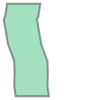

In [69]:
bounded_polygon

In [72]:


# Usage
save_polygon_to_json(bounded_polygon)

Successfully saved polygon to bounded_polygon.json


## Reading Parquet

In [98]:
import pandas as pd
import json
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.vectorized import contains
import s3fs
import boto3

# Initialize boto3 session and get credentials
session = boto3.Session()
credentials = session.get_credentials()

# Initialize S3 filesystem with boto3 credentials
s3 = s3fs.S3FileSystem(
    key=credentials.access_key,
    secret=credentials.secret_key,
    token=credentials.token,  # This will be included if using temporary credentials
    anon=False
)
# Read the parquet file
s3_path = 's3://birdsbucker/ebd_US-VA_smp_relApr-2025.parquet'
df_birds = pd.read_parquet(s3_path, filesystem=s3)

# Load the bounded polygon
with open('bounded_polygon.json', 'r') as f:
    polygon_data = json.load(f)
    coordinates = polygon_data['geometry']['coordinates'][0]
    bounded_polygon = Polygon(coordinates)

# Create points array
points = np.column_stack((df_birds['LONGITUDE'].values, df_birds['LATITUDE'].values))

# Check which points are within polygon
mask = contains(bounded_polygon, points[:, 0], points[:, 1])

# Filter dataframe
df_birds_filtered = df_birds[mask].reset_index(drop=True)

print(f"Original dataset: {len(df_birds)} points")
print(f"Filtered dataset: {len(df_birds_filtered)} points")

Original dataset: 100000 points
Filtered dataset: 43 points


/tmp/ipykernel_181/212778073.py:34: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = contains(bounded_polygon, points[:, 0], points[:, 1])
